Approach: Our .nc file contains two relvant infos: the radiance reading at each pixel, and the x,y angles that correspond to each pixel. These angles can be used to calculate the coordinate of each pixel. If we want to resample our image, we can simply resample the radian coordinates and then re-calculate geo coordinates on the resampled angles.

Idea: assign downsampled data to datset object and convert to geotiff

In [3]:
# from netCDF4 import Dataset
# import numpy as np
# import pprint
# import statistics
# import matplotlib.pyplot as plt
# import skimage.measure
import xarray

In [4]:
# file_path = 'data/OR_ABI-L1b-RadC-M6C16_G16_s20232671621174_e20232671623558_c20232671624030.nc'
# OES Imager Projection
# file_path = 'data/goes16_abi_conus_lat_lon.nc'
# file_path = 'data/GOES/noaa-goes16/ABI-L1b-RadC/2023/268/00/OR_ABI-L1b-RadC-M6C01_G16_s20232680001174_e20232680003547_c20232680003588.nc'
file_path = 'data/GOES/noaa-goes16/ABI-L1b-RadC/2023/268/16/OR_ABI-L1b-RadC-M6C01_G16_s20232681601174_e20232681603547_c20232681603586.nc'
# Open the file using the netCDF4 library
# coords = Dataset('data/goes16_abi_conus_lat_lon.nc')

# nc = Dataset(file_path)
xds = xarray.open_dataset(file_path)

# nc

In [6]:
# ds_coarse = xds.coarsen(lon=4, lat=4, boundary='pad').mean()
scale_factor = 4

ds_coarse = xds.coarsen(x=scale_factor, y=scale_factor, boundary='exact').mean()
ds_coarse.to_netcdf('data/resampled4.nc')

ds_coarse['Rad']

/var/folders/d6/6c5dlhy53xbg63xwm0wnxr8r0000gn/T/ipykernel_8506/2940275207.py:5: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_coarse.to_netcdf('data/resampled4.nc')
/var/folders/d6/6c5dlhy53xbg63xwm0wnxr8r0000gn/T/ipykernel_8506/2940275207.py:5: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_coarse.to_netcdf('data/resampled4.nc')


<xarray.DataArray 'Rad' (y: 750, x: 1250)>
array([[      nan,       nan,       nan, ..., 229.67383, 213.27943,
        160.23874],
       [      nan,       nan,       nan, ..., 179.78006, 175.92253,
        175.8718 ],
       [      nan,       nan,       nan, ..., 137.19522, 141.45879,
        136.53539],
       ...,
       [231.45032, 127.90675, 117.95845, ..., 254.89987, 312.40717,
        322.25397],
       [160.64479, 133.3377 ,  96.43764, ..., 279.51685, 326.56827,
        398.1859 ],
       [103.34053,  93.44299,  91.00667, ..., 300.42862, 340.06955,
        428.2846 ]], dtype=float32)
Coordinates:
    t        datetime64[ns] 2023-09-25T16:02:36.093404032
  * y        (y) float64 0.1282 0.1281 0.128 0.1278 ... 0.04452 0.04441 0.0443
  * x        (x) float64 -0.1013 -0.1012 -0.1011 ... 0.03836 0.03847 0.03858
    y_image  float32 0.08624
    x_image  float32 -0.03136
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

/var/folders/d6/6c5dlhy53xbg63xwm0wnxr8r0000gn/T/ipykernel_4396/2771440381.py:1: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_coarse.to_netcdf('data/resampled.tif', mode='a')
/var/folders/d6/6c5dlhy53xbg63xwm0wnxr8r0000gn/T/ipykernel_4396/2771440381.py:1: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_coarse.to_netcdf('data/resampled.tif', mode='a')


In [150]:
def calculate_degrees_nc(file_id):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    # projection_info = file_id['goes_imager_projection']
    # dataset['goes_imager_projection'].longitude_of_projection_origin
    
    
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon

def calculate_degrees_xarr(file_id):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    # projection_info = file_id['goes_imager_projection']
    # dataset['goes_imager_projection'].longitude_of_projection_origin
    
    
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon

def check_spacing(arr):
    deltas = []
    delta2 = []
    
    print(arr.shape)
    for i in range(0, len(arr)-1):
        deltas.append(arr[i+1]-arr[i])

    statistics.stdev(deltas)
    
    # for i in range(0, len(deltas)-1):
    #     delta2.append(deltas[i+1]-deltas[i])
        
    deltas = np.array(deltas)
    print('Number of different spacings: ', len(np.unique(deltas)))
    print('STD DEV: ', statistics.stdev(deltas))

In [160]:
# nc.variables['x'][:].data.shape
# x_rads = nc.variables['x'][:].data
# y_rads = nc.variables['y'][:].data
# data = nc.variables['Rad'][:].data
x_rads = xds['x']
y_rads = xds['y']
data = xds['Rad']


In [154]:
xds['x']

<xarray.DataArray 'x' (x: 5000)>
array([-0.101346, -0.101318, -0.10129 , ...,  0.03857 ,  0.038598,  0.038626])
Coordinates:
    t        datetime64[ns] ...
  * x        (x) float64 -0.1013 -0.1013 -0.1013 ... 0.03857 0.0386 0.03863
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    units:          rad
    axis:           X
    long_name:      GOES fixed grid projection x-coordinate
    standard_name:  projection_x_coordinate

In [156]:
scale_factor = 2
x_rads = skimage.measure.block_reduce(x_rads, scale_factor, np.mean)
y_rads = skimage.measure.block_reduce(y_rads, scale_factor, np.mean)
data = skimage.measure.block_reduce(data, scale_factor, np.mean)



x_rads.shape

(2500,)

In [157]:
xds['x'] = x_rads
xds['y'] = y_rads
xds['Rad'] = data 

ValueError: conflicting sizes for dimension 'x': length 2500 on 'x' and length 5000 on {'y': 'Rad', 'x': 'Rad'}

0.038626 -0.101346 -0.031360004
0.038528003 -0.101247996 -0.03136


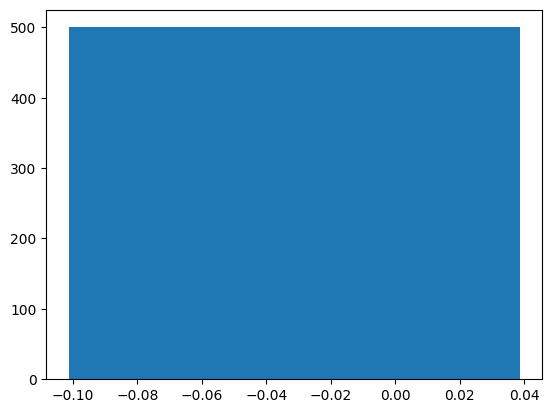

In [122]:
print(
    nc.variables['x'][:].data.max(),
    nc.variables['x'][:].data.min(),
    nc.variables['x'][:].data.mean()
)

# np.histogram(nc.variables['x'][:].data)
plt.hist( nc.variables['x'][:].data)

print(
    x_rads.max(),
    x_rads.min(),
    x_rads.mean()
)

# np.histogram(nc.variables['x'][:].data)


(array([125., 125., 125., 125., 125., 125., 125., 125., 125., 125.]),
 array([-0.101304 , -0.0873152, -0.0733264, -0.0593376, -0.0453488,
        -0.03136  , -0.0173712, -0.0033824,  0.0106064,  0.0245952,
         0.038584 ]),
 <BarContainer object of 10 artists>)

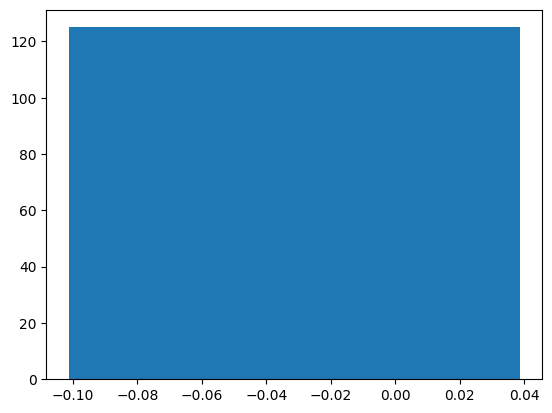

In [114]:
plt.hist( x_rads.data)


In [73]:
# nc.keys()
# pprint.pprint(nc.__dict__)
nc.variables
abi_lat, abi_lon = calculate_degrees(nc)

check_spacing(nc.variables['x'])
check_spacing(nc.variables['y'])

check_spacing(abi_lat.data[:,0])
check_spacing(abi_lon.data[:,0])

# check_spacing(abi_lon)
check_spacing(coords.variables['latitude'][:,0][~coords.variables['latitude'][:,0].mask].data)
check_spacing(coords.variables['longitude'][:,0][~coords.variables['longitude'][:,0].mask].data)


# nc['Rad'].shape

(5000,)
Number of different spacings:  4
STD DEV:  2.2282213789397835e-09
(3000,)
Number of different spacings:  4
STD DEV:  2.257144505068606e-09
(3000,)
Number of different spacings:  1634
STD DEV:  0.1836374814656229
(3000,)
Number of different spacings:  1508
STD DEV:  2.7594423518546627
(1226,)
Number of different spacings:  1225
STD DEV:  0.008297382288259509
(1226,)
Number of different spacings:  1200
STD DEV:  0.05205729299139835
